In [1]:
import torch 
import torchvision # torchvision package : 컴퓨터 비전을 위한 유명 데이터셋, 모델 아키텍처, 이미지 변형등을 포함
import torch.nn as nn # nn : neural netwroks (define class) attribute를 활용해 state를 저장하고 활용
import torch.optim as optim # 최적화 알고리즘
import torch.nn.functional as F # (define function) 인스턴스화 시킬 필요없이 사용 가능
from PIL import Image
from torchvision import transforms, datasets # transforms : 데이터를 조작하고 학습에 적합하게 만듦.
from torch.utils.data import Dataset, DataLoader
# dataset : 샘플과 정답(label)을 저장
# DataLoader : Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다.

In [2]:
epochs = 10
batch_size = 128 #  batch size of 128

device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_transform = transforms.Compose([
    # 224 × 224 × 3 input image
    transforms.Resize(224),
    #The first form of data augmentation consists of generating image translations and horizontal reflections
    transforms.RandomHorizontalFlip(0.5),#주어진 확률로 주어진 이미지를 무작위로 수평으로 뒤집습니다.
    #The second form of data augmentation consists of altering the intensities of the RGB channels in training images.
    transforms.ColorJitter(hue=0.3),#torchvision.transforms.ColorJitter( 밝기 = 0 , 대비 = 0 , 채도 = 0 , 색조 = 0 )
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])
train_data = datasets.CIFAR10(
    root = 'data',
    train = True,
    download = True,
    transform=train_transform
)
test_data = datasets.CIFAR10(
    root = 'data',
    train = False,
    download = True,
    transform=test_transform
)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class AlexNet(nn.Module):
  def __init__(self):
    super(AlexNet,self).__init__()
    self.conv_layers = nn.Sequential(
        #The first convolutional layer filters the 224 × 224 × 3 input image with 96 kernels of size 11 × 11 × 3 with a stride of 4 pixels
        nn.Conv2d(3,96,kernel_size=11,stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3,stride=2),#26x26x96
        #The second convolutional layer takes as input the (response-normalized and pooled) output of the first convolutional layer and filters it with 256 kernels of size 5 × 5 × 48.
        nn.Conv2d(96,256,kernel_size=5,padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3,stride=2),
        #The third convolutional layer has 384 kernels of size 3 × 3 × 256 connected to the (normalized, pooled) outputs of the second convolutional layer.
        nn.Conv2d(256,384,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        #The fourth convolutional layer has 384 kernels of size 3 × 3 × 192
        nn.Conv2d(384,384,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        # fifth convolutional layer has 256 kernels of size 3 × 3 × 192
        nn.Conv2d(384,256,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 5 * 5, 4096),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(4096,4096),
        nn.ReLU(),
        nn.Linear(4096, 10),
    )

  def forward(self,x):
    output = self.conv_layers(x)
    output = output.view(output.size(0), -1)
    output = self.classifier(output)
      
    return output

In [5]:
model = AlexNet().to(device)
loss_fn = F.cross_entropy
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=0.0005) #stochastic gradient descent(momentum of 0.9, and weight decay of 0.0005.)
print(model)

AlexNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6400, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): L

In [6]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


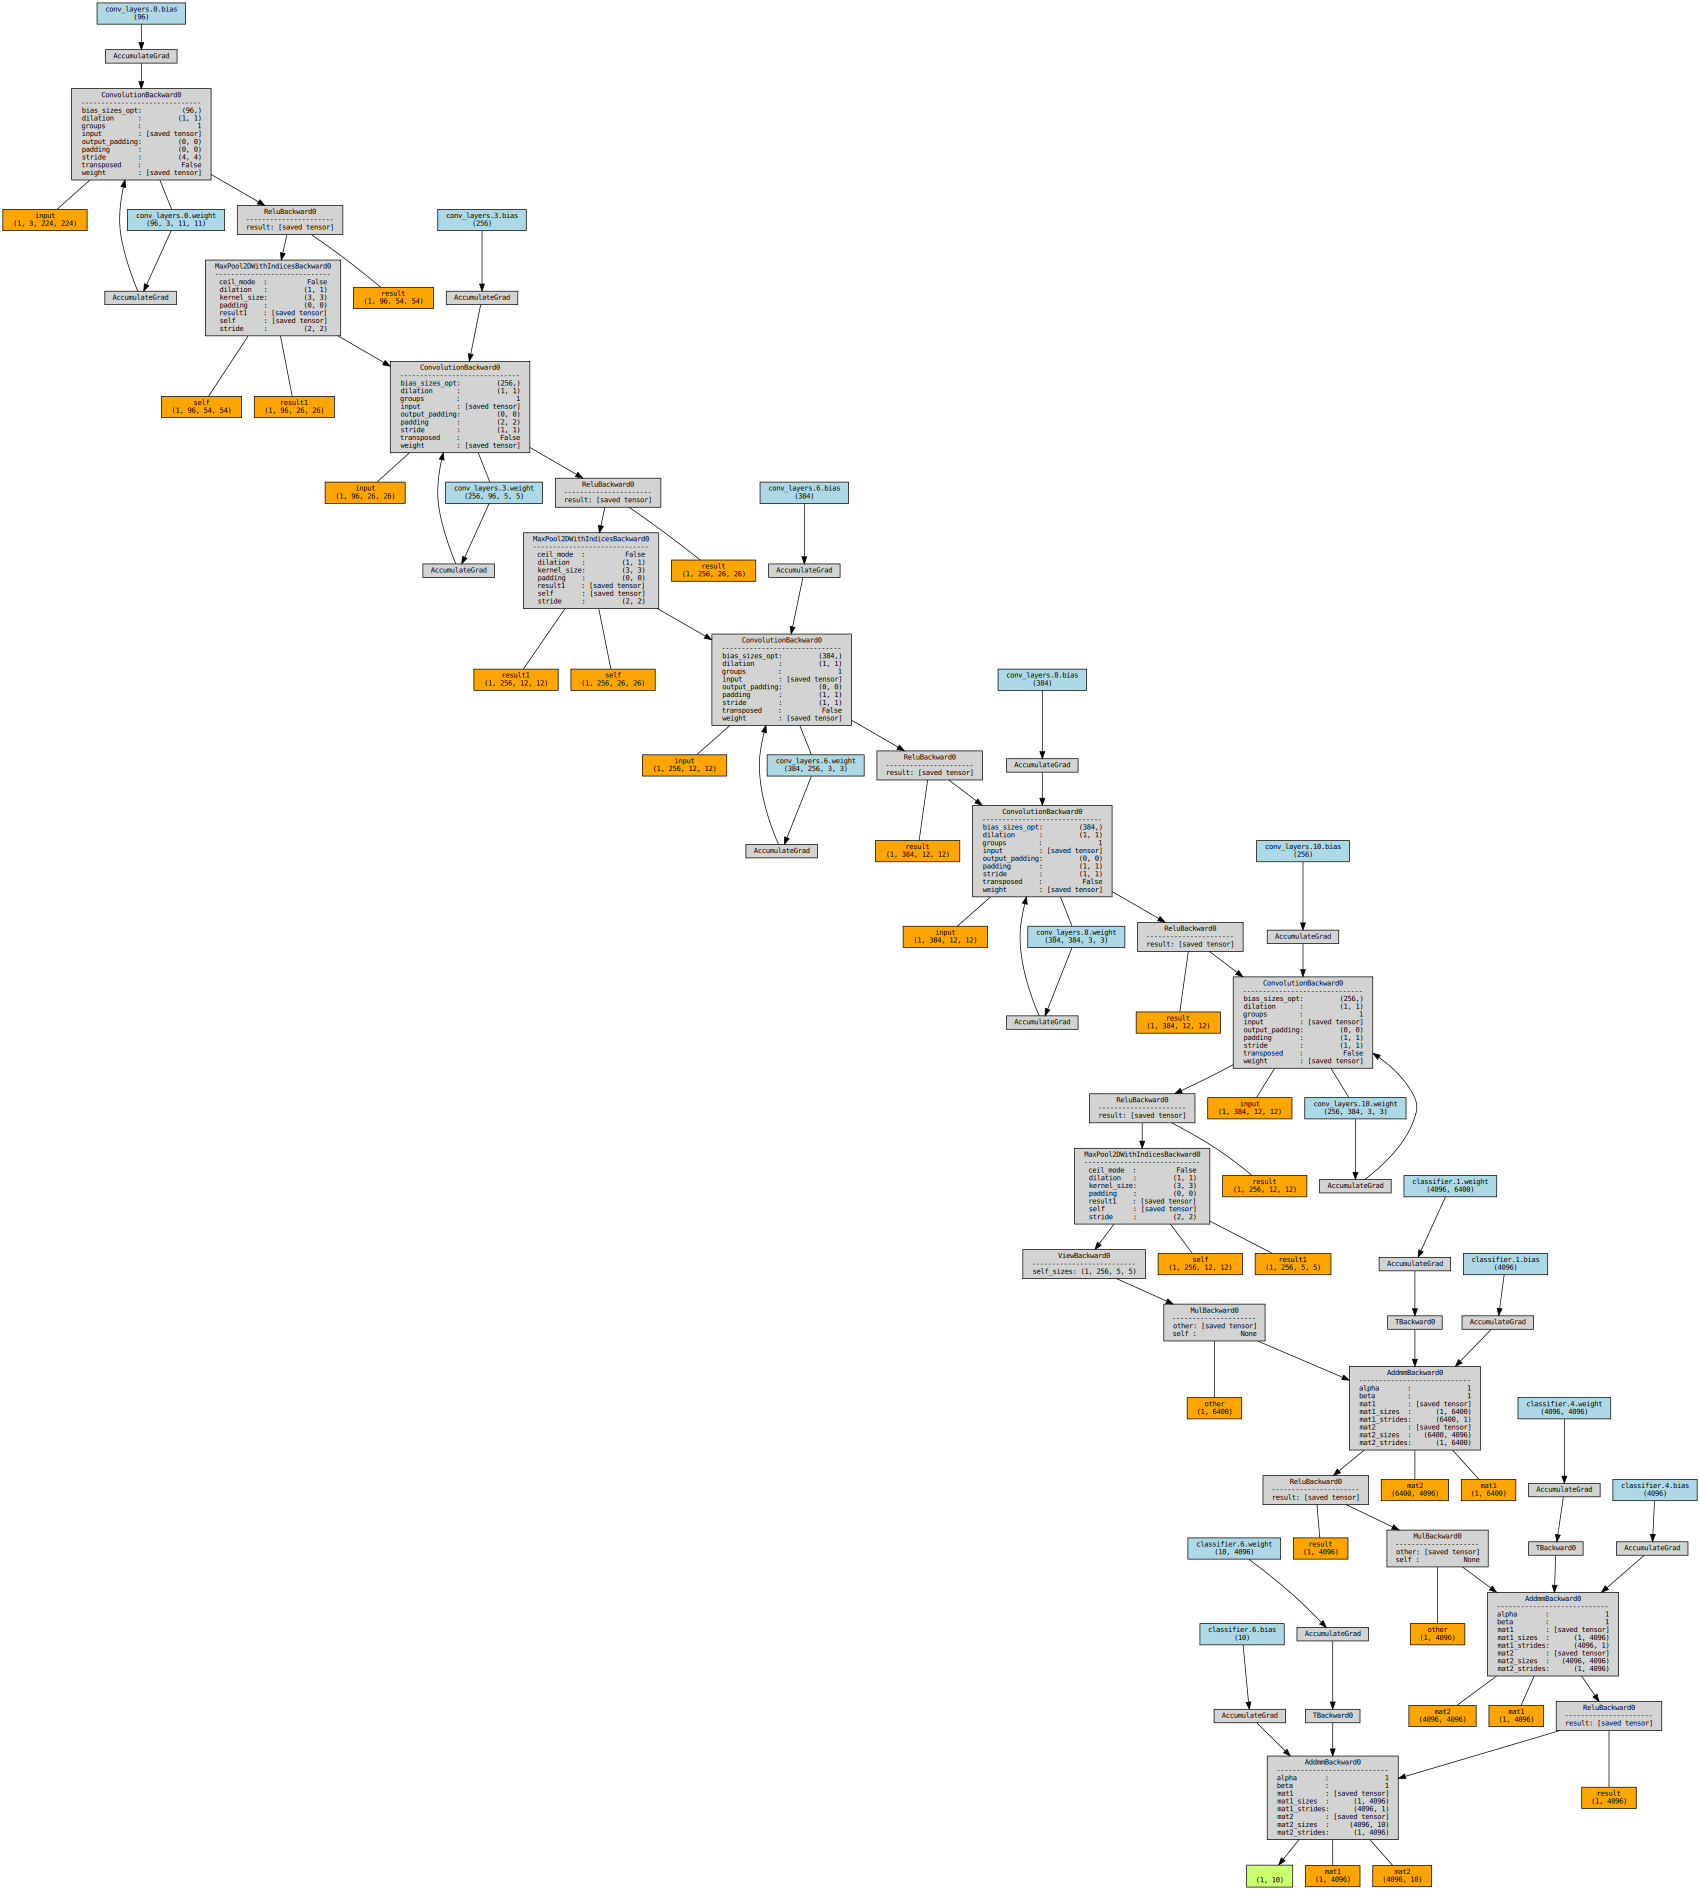

In [7]:
from torchviz import make_dot

x = torch.zeros(1,3,224,224)
models = AlexNet()
#make_dot(models(x),params=dict(list(models.named_parameters())))
make_dot(models(x),params=dict(list(models.named_parameters())),show_attrs=True, show_saved=True)

In [8]:
train_accu = []
train_losses = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss=0
    correct=0
    total=0

    for batch_idx, (data, target) in enumerate(train_loader):
        # enumberate() : 인덱스와 원소로 이루어진 튜플(tuple)을 만들어줌
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 항상 backpropagation 하기전에 미분(gradient)을 zero로 만들어주고 시작해야 한다.
        output = model(data)
        loss = loss_fn(output, target) # criterion = loss_fn
        loss.backward()
        optimizer.step() # step() : 파라미터를 업데이트함

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
   
    train_accu.append(accu)
    train_losses.append(train_loss)
    
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [11]:
eval_losses=[]
eval_accu=[]

def test(model, device, test_loader):
    model.eval() # dropout,batchnorm등의 기능을 비활성화 시켜 추론 모드로 조정
    running_loss=0
    correct=0
    total=0
    with torch.no_grad(): # autograd engine을 비활성화 시켜 필요한 메모리를 줄여주고 연산속도를 증가시킴
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            running_loss += loss_fn(output, target, reduction='sum').item() # loss.item() 으로 loss가 갖고 있는 스칼라 값을 가져올 수 있음
            pred = output.max(1, keepdim=True)[1]# 텐서에서 최대값을 구하는 함수, keepdim ( bool ) – 출력 텐서가 dim유지되었는지 여부. 기본값: False., https://www.inflearn.com/questions/282058
            total += target.size(0)
            #correct += pred.eq(labels).sum().item()
            correct += pred.eq(target.view_as(pred)).sum().item() # pred.eq(data)는 pred배열과 data가 일치하느냐를 검사

        test_loss = running_loss/len(test_loader.dataset)  
        accu=100.*correct/total
 
        eval_losses.append(test_loss)
        eval_accu.append(accu)
        print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 
        print('-----------------------------------')

In [13]:
for epoch in range(1, epochs+1):
  print(f"Epoch {epoch}")
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

Epoch 1
Train Loss: 1.898 | Accuracy: 30.566
Test Loss: 1.800 | Accuracy: 35.600
-----------------------------------
Epoch 2
Train Loss: 1.594 | Accuracy: 42.326
Test Loss: 1.423 | Accuracy: 48.890
-----------------------------------
Epoch 3
Train Loss: 1.355 | Accuracy: 51.716
Test Loss: 1.162 | Accuracy: 58.430
-----------------------------------
Epoch 4
Train Loss: 1.152 | Accuracy: 59.848
Test Loss: 1.044 | Accuracy: 63.320
-----------------------------------
Epoch 5
Train Loss: 0.994 | Accuracy: 65.270
Test Loss: 0.886 | Accuracy: 69.080
-----------------------------------
Epoch 6
Train Loss: 0.882 | Accuracy: 69.322
Test Loss: 0.819 | Accuracy: 72.040
-----------------------------------
Epoch 7
Train Loss: 0.802 | Accuracy: 72.152
Test Loss: 0.741 | Accuracy: 74.020
-----------------------------------
Epoch 8
Train Loss: 0.733 | Accuracy: 74.530
Test Loss: 0.674 | Accuracy: 76.870
-----------------------------------
Epoch 9
Train Loss: 0.680 | Accuracy: 76.572
Test Loss: 0.636 | 

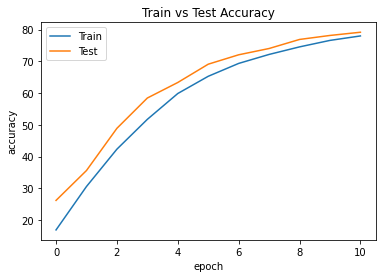

In [17]:
import matplotlib.pyplot as plt


plt.plot(train_accu)
plt.plot(eval_accu)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

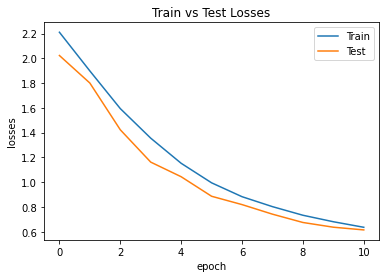

In [18]:
plt.plot(train_losses)
plt.plot(eval_losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

In [16]:
classes = ['airplane', 'automobile', 'bird','cat','deer', 'dog', 'frog','horse','ship','truck']

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device),target.to(device)
        outputs = model(data)
        _, predictions = torch.max(outputs, 1)
        #predictions = outputs.max(1, keepdim=True)[1]
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(target, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 83.2 %
Accuracy for class: automobile is 89.9 %
Accuracy for class: bird  is 67.9 %
Accuracy for class: cat   is 56.3 %
Accuracy for class: deer  is 77.3 %
Accuracy for class: dog   is 67.9 %
Accuracy for class: frog  is 87.3 %
Accuracy for class: horse is 83.1 %
Accuracy for class: ship  is 89.8 %
Accuracy for class: truck is 88.7 %
